In [7]:
from transformers import BridgeTowerModel, BridgeTowerProcessor
import torch
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image

### 1 Model Investigation

In [2]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("BridgeTower/bridgetower-base")

#### 1.1 Model Architecture

In [48]:
model

BridgeTowerModel(
  (cross_modal_text_transform): Linear(in_features=768, out_features=768, bias=True)
  (cross_modal_image_transform): Linear(in_features=768, out_features=768, bias=True)
  (token_type_embeddings): Embedding(2, 768)
  (vision_model): BridgeTowerVisionModel(
    (visual): BridgeTowerVisionTransformer(
      (embeddings): BridgeTowerVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (position_embedding): Embedding(325, 768)
      )
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): BridgeTowerTransformer(
        (resblocks): ModuleList(
          (0-11): 12 x BridgeTowerResidualAttention(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): ModuleDict(
              (c

#### 1.2 Model Function

In [49]:
from transformers import BridgeTowerProcessor, BridgeTowerModel
import requests
from PIL import Image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "hello world"

processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
# Prepare inputs
encoding = processor(image, text, return_tensors="pt")
# Forward pass
outputs = model(**encoding)
outputs.keys()
#odict_keys(['text_feats', 'image_feats', 'pooler_output'])


odict_keys(['text_features', 'image_features', 'pooler_output'])

In [50]:
outputs.image_features

tensor([[[ 0.4191,  0.1899, -0.6848,  ..., -1.0601, -1.2401, -1.7667],
         [-0.6503, -0.2314, -0.8267,  ..., -0.0675, -0.3931, -1.6485],
         [ 0.4087, -0.2456, -0.1298,  ...,  0.1705, -0.5598, -1.6388],
         ...,
         [ 0.2994,  0.2039, -0.8922,  ...,  0.4237, -0.0646, -1.6678],
         [-1.2473, -0.4323, -1.1980,  ..., -0.9151, -0.4366, -2.5395],
         [ 0.5453,  0.4352, -1.0627,  ...,  0.0493,  0.5887, -2.0345]]],
       grad_fn=<NativeLayerNormBackward0>)

### 2 Extracting Layer Activations

#### 2.1 Define Model

In [272]:
model = model = AutoModel.from_pretrained("BridgeTower/bridgetower-base")

In [273]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [194]:
# Get relevant layers: Start with only convolutional layer
model_weights = []

conv_layers = []

model_children = list(model.children())

vision_model = list(model_children[3].children())
vision_model = list(vision_model[0].children())
patch_embedding = list(vision_model[0].children())
patch_embedding = patch_embedding[0]

#### 2.2 Define Inputs

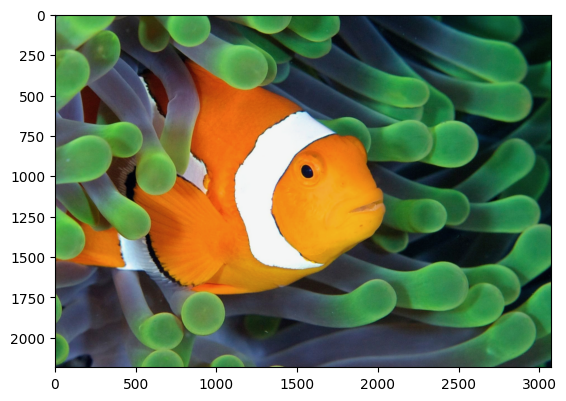

In [271]:
image = Image.open(str('tensorflow_tutorial\images\clown-fish.png'))
plt.imshow(image)

In [270]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [274]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 256, 256])
Image shape after: torch.Size([1, 3, 256, 256])


#### 2.3 Get Layer Extraction

In [195]:
image = patch_embedding(image)
output = image
name = (str(patch_embedding))
print(output.shape)

torch.Size([1, 768, 16, 16])


In [196]:
feature_map = output.squeeze(0)
gray_scale = torch.sum(feature_map,0)
gray_scale = gray_scale / feature_map.shape[0]
fm = gray_scale.data.cpu().numpy()
print(fm.shape)

(16, 16)


Text(0.5, 1.0, 'Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)')

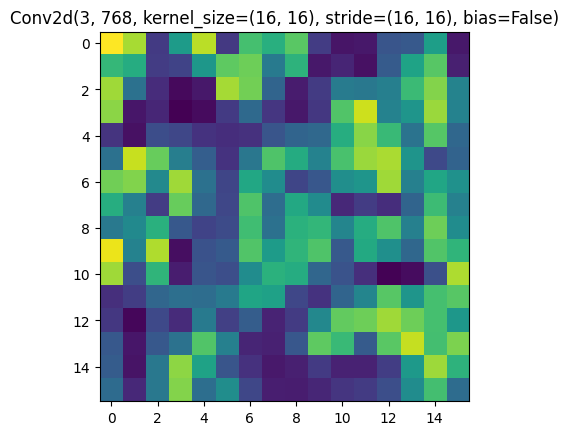

In [197]:
plt.imshow(fm)
plt.title(name)

### 3 Forward Passes
Just passing the inputs through the layer does not provide us a comprehensive feature map since it disregards layers before it. Instead, we can use forward hooks that mark important layers in our model and extract their output to a dictionary while the full model is running.

In [9]:
# only run if image can't be found
os.chdir("..")

#### 3.1 Set Up Model and Hooks

In [39]:
# input (text and image)
processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
image = Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB')
text = "An elephant in grass"
inputs = processor(image, text, return_tensors='pt')

# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

print(hook_names)
print(hooks_to_remove)

['patch_embed', 'final_vis', 'final_text', 'cm_image_pooler', 'cm_text_pooler', 'text_encoder_0', 'text_encoder_1', 'text_encoder_2', 'text_encoder_3', 'text_encoder_4', 'text_encoder_5', 'text_encoder_6', 'text_encoder_7', 'text_encoder_8', 'text_encoder_9', 'text_encoder_10', 'text_encoder_11', 'cm_image_0', 'cm_image_1', 'cm_image_2', 'cm_image_3', 'cm_image_4', 'cm_image_5', 'cm_text_0', 'cm_text_1', 'cm_text_2', 'cm_text_3', 'cm_text_4', 'cm_text_5']
{'resblock_0': <torch.utils.hooks.RemovableHandle object at 0x000001B842E4A550>, 'resblock_1': <torch.utils.hooks.RemovableHandle object at 0x000001B859FDE790>, 'resblock_2': <torch.utils.hooks.RemovableHandle object at 0x000001B859FDFBD0>, 'resblock_3': <torch.utils.hooks.RemovableHandle object at 0x000001B859FDFAD0>, 'resblock_4': <torch.utils.hooks.RemovableHandle object at 0x000001B859FDF910>, 'resblock_5': <torch.utils.hooks.RemovableHandle object at 0x000001B859FDF8D0>, 'resblock_6': <torch.utils.hooks.RemovableHandle object at 

#### 3.2 Get Feature Maps

In [40]:
# forward pass [with feature extraction]
preds = model(**inputs)

print(len(features))
print(len(features.values()))

# detach the hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

40
40


In [41]:
for fm in features.values():
    print(fm.shape)

torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
torch.Size([768, 18, 18])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([1, 6, 768])
torch.Size([1, 768])
torch.Size([1, 6, 768])
torch.Size([1, 325, 768])
torch.Size([768])
torch.Size([768])


In [42]:
names = []
processed = []

for name, tensor in features.items():
        tensor = tensor.squeeze(0) # Remove batch dimension if present

        if len(tensor.shape) == 3:
            # If the tensor has shape [C, H, W], resize it to (18, 18)
            feature_map = tensor
        else:
            channel = tensor.numel() // (16 * 16)
            # If the tensor has shape [H, W] or [C], reshape it to (18, 18)
            feature_map = tensor.view(channel, 16, 16)  # Reshape to (1, 1, 768) for consistency
            # feature_map = F.interpolate(feature_map, size=(18, 18), mode='bilinear', align_corners=False)
            # feature_map = feature_map.squeeze(0).squeeze(0)
        # print(feature_map.shape)

        gray_scale = torch.sum(feature_map, 0)
        gray_scale = gray_scale / feature_map.shape[0]

        processed.append(gray_scale.data.cpu().numpy())
        names.append(name)
#         # normalize the values
#         feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

#         processed[name] = feature_map.data.cpu().numpy()

for fm in processed:
     print(fm.shape)

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(18, 18)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


#### 3.3 Visualize The Feature Maps

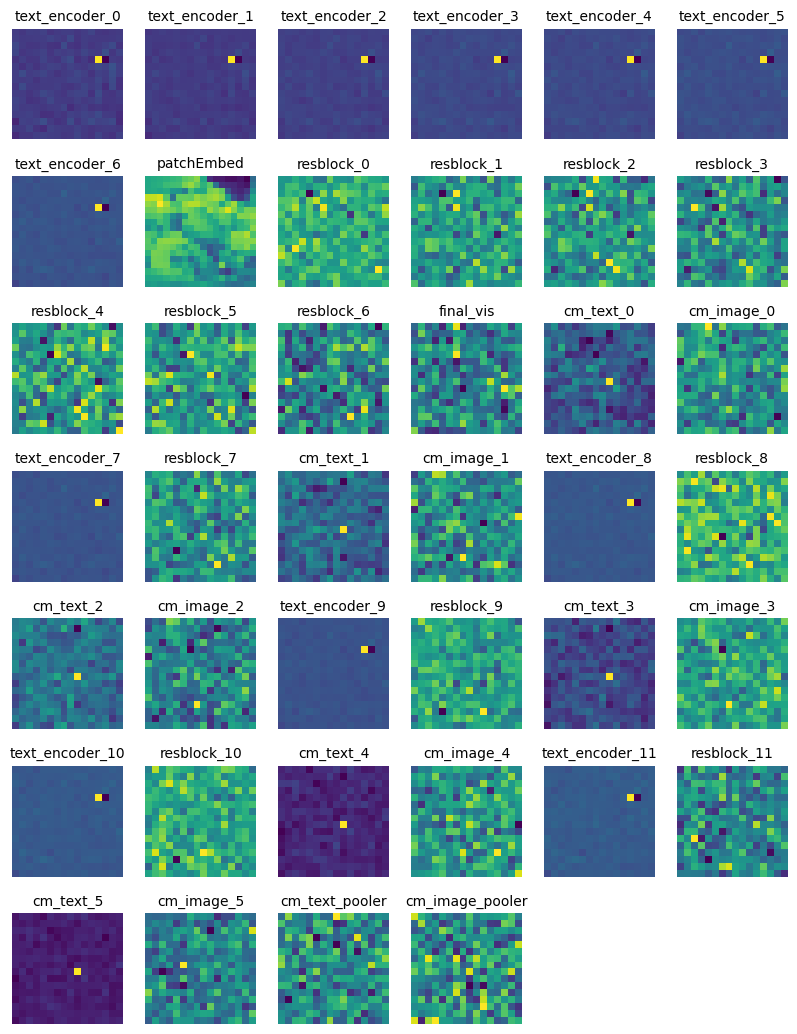

In [56]:
fig = plt.figure(figsize=(10,15))
for i in range(len(processed)):
    a = fig.add_subplot(8, 6, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i], fontsize=10)
# plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### 4 Loop Through Two Inputs
The goal is to pass frames from a movie to this model. This requires us to loop through the model and change the inputs while still collecting layer activations for each input. Let's try a simplified version of this with just two different photos as our two inputs to loop through.

#### 4.1 Model Set-up
We can define the hooks before we run our model. We can continue to loop through the inputs without removing and re-registering our hooks because our model and layers of interest remain the same. We want to prioritize the computing speed of our model.

In [54]:
# set-up
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

print(hook_names)
print(hooks_to_remove)

['patch_embed', 'final_vis', 'final_text', 'cm_image_pooler', 'cm_text_pooler', 'text_encoder_0', 'text_encoder_1', 'text_encoder_2', 'text_encoder_3', 'text_encoder_4', 'text_encoder_5', 'text_encoder_6', 'text_encoder_7', 'text_encoder_8', 'text_encoder_9', 'text_encoder_10', 'text_encoder_11', 'cm_image_0', 'cm_image_1', 'cm_image_2', 'cm_image_3', 'cm_image_4', 'cm_image_5', 'cm_text_0', 'cm_text_1', 'cm_text_2', 'cm_text_3', 'cm_text_4', 'cm_text_5']
{'resblock_0': <torch.utils.hooks.RemovableHandle object at 0x000001E84E621C50>, 'resblock_1': <torch.utils.hooks.RemovableHandle object at 0x000001E848A4A990>, 'resblock_2': <torch.utils.hooks.RemovableHandle object at 0x000001E8411A2810>, 'resblock_3': <torch.utils.hooks.RemovableHandle object at 0x000001E84EB25CD0>, 'resblock_4': <torch.utils.hooks.RemovableHandle object at 0x000001E83F1C3D50>, 'resblock_5': <torch.utils.hooks.RemovableHandle object at 0x000001E84E163A10>, 'resblock_6': <torch.utils.hooks.RemovableHandle object at 

#### 4.2 Define Inputs

In [33]:
processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
images = [Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB'),
          Image.open(str('tensorflow_tutorial\images\ice-cream.png')).convert('RGB')]
texts = ["An elephant in grass",
         "A bowl of ice cream"]

inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

#### 4.3 Loop Through the Inputs

In [34]:
# A dictionary for storing each run
data = {}

for i, input in enumerate(inputs):
    run_name = f"run_{i}"
    preds = model(**input)

    names = []
    processed = []

    for name, tensor in features.items():
            tensor = tensor.squeeze(0) # Remove batch dimension if present

            if len(tensor.shape) == 3:
                feature_map = tensor
            else:
                channel = tensor.numel() // (16 * 16)
                feature_map = tensor.view(channel, 16, 16)

            gray_scale = torch.sum(feature_map, 0)
            gray_scale = gray_scale / feature_map.shape[0]

            processed.append(gray_scale.data.cpu().numpy())
            names.append(name)
    
    data[run_name] = [names, processed]

# Remove hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

#### 4.4 Visualize the Runs

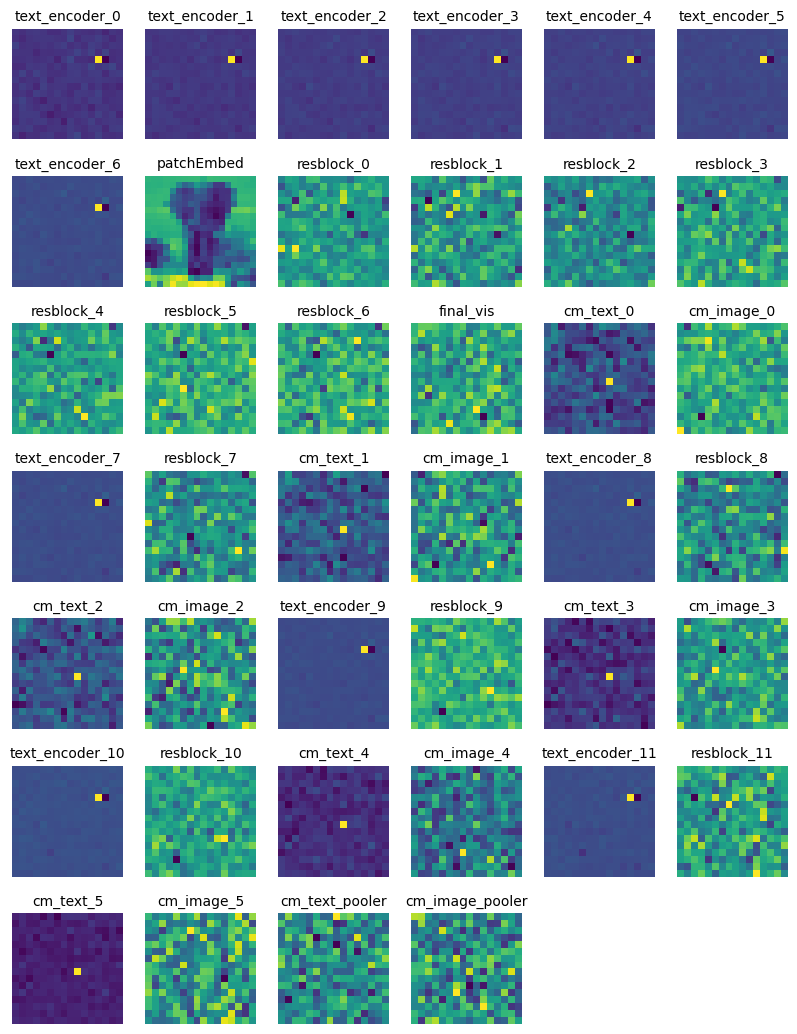

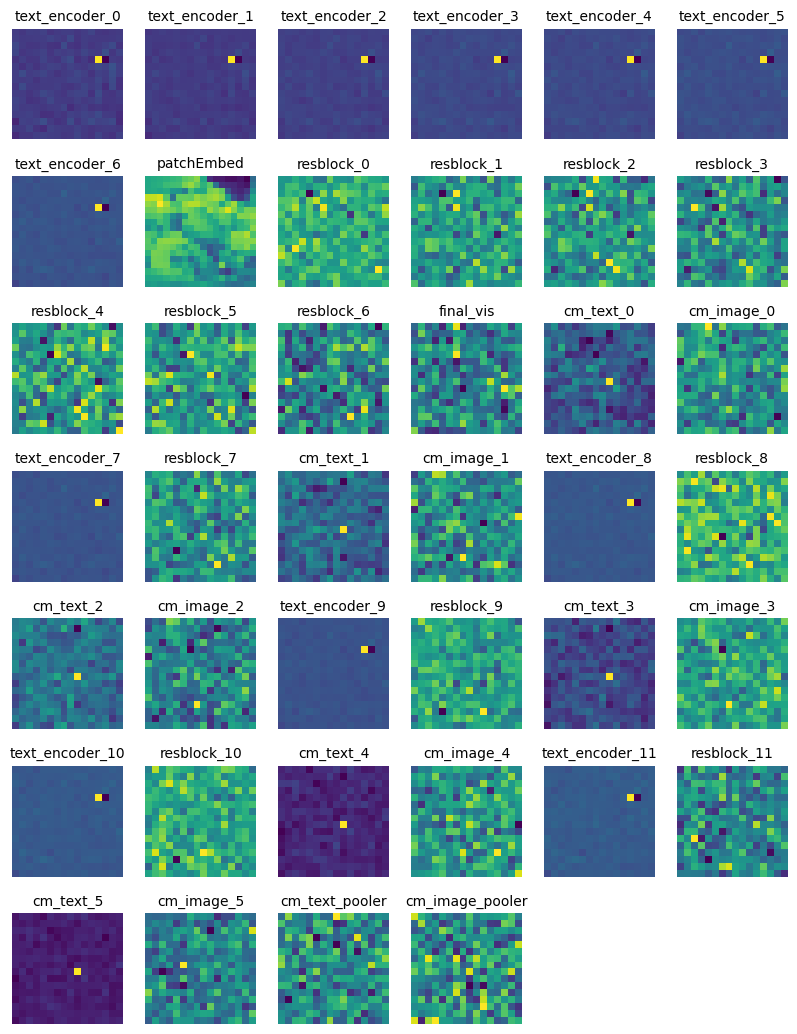

In [35]:
for run, info in data.items():
    names = info[0]
    processed = info[1]
    fig = plt.figure(figsize=(10,15))
    for i in range(len(processed)):
        a = fig.add_subplot(8, 6, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i], fontsize=10)

#### 4.5 Adjust Data Storage
We want data from each layer to be stored together for each input. Let's set it up so that each new run appends an additional tensor each layer.

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BridgeTowerModel.from_pretrained("BridgeTower/bridgetower-base")
model = model.to(device)

# placeholder for batch features
features = {}
def get_features(name):
    def hook(model, input, output):
        # detached_outputs = [tensor.detach() for tensor in output]
        last_output = output[-1].detach()
        features[name] = last_output  # detached_outputs
    return hook

hook_names = []
hooks_to_remove = {}
# register forward hooks with layers of choice
# First, convolutional layers
patch_embed = model.vision_model.visual.embeddings.patch_embedding.register_forward_hook(get_features('patchEmbed'))
hook_names.append('patch_embed')

final_vis = model.vision_model.visual.ln_post.register_forward_hook(get_features('final_vis'))
hook_names.append('final_vis')

final_text = model.text_model.pooler.activation.register_forward_hook(get_features('final_text'))
hook_names.append('final_text')

cm_image_pooler = model.cross_modal_image_pooler.register_forward_hook(get_features('cm_image_pooler'))
hook_names.append('cm_image_pooler')

cm_text_pooler = model.cross_modal_text_pooler.register_forward_hook(get_features('cm_text_pooler'))
hook_names.append('cm_text_pooler')

# Next: residual attention layers
for i, resblock in enumerate(model.vision_model.visual.transformer.resblocks):
    hook_name = f"resblock_{i}"

    hook_ref = resblock.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Text encoder layers
for i, encoder in enumerate(model.text_model.encoder.layer):
    hook_name = f"text_encoder_{i}"
    hook_names.append(hook_name)

    hook_ref = encoder.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Next: Cross modal image layers
for i, cm_image in enumerate(model.cross_modal_image_layers):
    hook_name = f"cm_image_{i}" 
    hook_names.append(hook_name)

    hook_ref = cm_image.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

# Lastly: Cross modal text layers
for i, cm_text in enumerate(model.cross_modal_text_layers):
    hook_name = f"cm_text_{i}"
    hook_names.append(hook_name)

    hook_ref = cm_text.register_forward_hook(get_features(hook_name))

    hooks_to_remove[hook_name] = hook_ref

processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-base")
images = [Image.open(str('tensorflow_tutorial\images\elephant.png')).convert('RGB'),
          Image.open(str('tensorflow_tutorial\images\ice-cream.png')).convert('RGB')]
texts = ["An elephant in grass",
         "A bowl of ice cream"]

inputs = [processor(image, text, return_tensors='pt') for image, text in zip(images, texts)]

In [58]:
# A dictionary for storing each run
maps = {}

for i, input in enumerate(inputs):
    preds = model(**input)

    for name, tensor in features.items():
            tensor = tensor.squeeze(0) # Remove batch dimension if present

            if len(tensor.shape) == 3:
                feature_map = tensor
            else:
                channel = tensor.numel() // (16 * 16)
                feature_map = tensor.view(channel, 16, 16)

            gray_scale = torch.sum(feature_map, 0)
            gray_scale = gray_scale / feature_map.shape[0]

            final_tensor = gray_scale.data.cpu().numpy()

            if name not in maps:
                 maps[name] = []
            
            maps[name].append(gray_scale.data.cpu().numpy())

# Remove hooks
patch_embed.remove()
final_vis.remove()
final_text.remove()
cm_image_pooler.remove()
cm_text_pooler.remove()

for hook_name, hook_ref in hooks_to_remove.items():
    hook_ref.remove()

[[ 3.47250886e-02 -5.06551675e-02  6.74540177e-02  8.82076919e-02
   4.29298356e-02 -8.84663910e-02 -8.39681402e-02  5.47428941e-03
   1.94601476e-01  4.67208400e-03 -2.89356187e-02 -7.45085329e-02
   1.40621532e-02 -2.06488803e-01  1.80625841e-02 -3.70033123e-02]
 [-2.41132136e-02 -1.47466645e-01  1.13887656e-02  6.10183664e-02
   7.40568936e-02  7.64164850e-02  7.26143038e-03 -1.66169498e-02
   3.05749983e-01 -1.23106517e-01  6.62652701e-02  5.22750169e-02
   1.90821201e-01  2.40042135e-02 -1.49720684e-01  2.04321404e-04]
 [ 2.33807534e-01 -2.91402005e-02  9.47740336e-04 -3.74924280e-02
   4.28664833e-02 -1.14564989e-02  8.19288790e-02  1.93222851e-01
  -5.60679175e-02  4.22132351e-02 -7.39068612e-02  1.78615734e-01
   7.78913051e-02 -7.19942078e-02  6.02927022e-02  2.49073282e-02]
 [ 2.02940628e-02 -1.89235387e-03 -2.91210250e-03 -1.79488987e-01
  -3.39632481e-02 -5.66020682e-02 -5.99238090e-03 -2.16643251e-02
   6.90816641e-02  2.59537399e-01  4.64709736e-02  2.37226993e-01
  -7.73

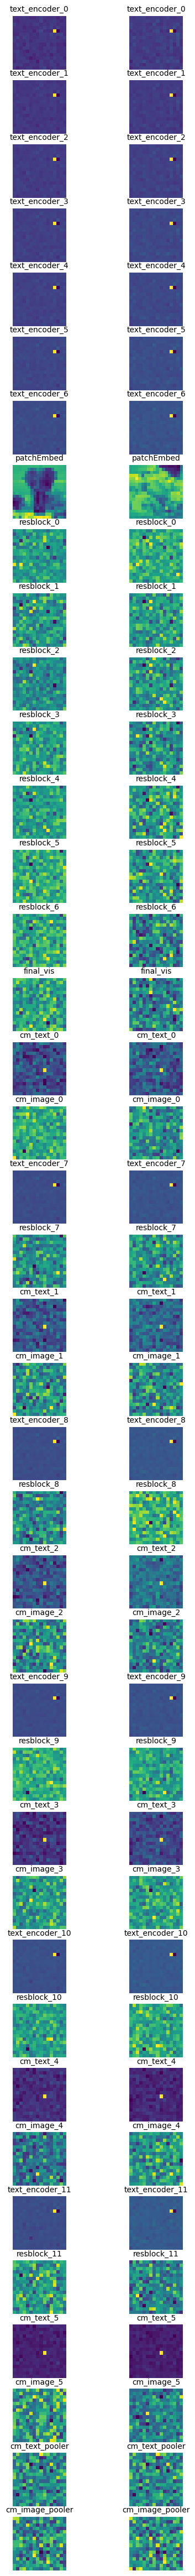

In [59]:
i = 0 # for plot position
fig = plt.figure(figsize=(5,60))
for name, tensors in maps.items():
    for tensor in tensors:
        i += 1
        a = fig.add_subplot(40, 2, i)
        imgplot = plt.imshow(tensor)
        a.axis("off")
        a.set_title(name, fontsize=10)